In [348]:
# Imports
%matplotlib inline
from capture_utils import loadmat_h5py
import h5py
import scipy.io as sio
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [91]:
arr = sio.loadmat("data/calibration/camera_params.mat")
type(arr["param_struct"])

numpy.ndarray

In [92]:
param_struct = arr["param_struct"]
cp1 = param_struct["CameraParameters1"]
cp1[0][0][0][0]["FocalLength"]

array([[1100.71192216, 1110.10079197]])

In [73]:
print(param_struct["RotationOfCamera2"][0][0])
print(param_struct["TranslationOfCamera2"][0][0][0])


[[ 0.99753515 -0.00598296  0.06991302]
 [ 0.00362475  0.99942174  0.03380886]
 [-0.07007487 -0.03347211  0.99698   ]]
[-5.08160554 70.83257561 94.34723876]


In [90]:
cp1[0][0][0][0]["FocalLength"]

array([[1100.71192216, 1110.10079197]])

In [93]:
param_struct["CameraParameters1"][0][0][0][0]["FocalLength"]

array([[1100.71192216, 1110.10079197]])

In [338]:
def extract_camera_intrinsics(CameraParameters):
    """
    Get intrinsics from param struct
    """
    focalLength = CameraParameters["FocalLength"][0]
    principalPoint = CameraParameters["PrincipalPoint"][0]
    radialDistortion = CameraParameters["RadialDistortion"][0]
    tangentialDistortion = CameraParameters["TangentialDistortion"][0]
    return focalLength, principalPoint, radialDistortion, tangentialDistortion

def extract_camera_params(filepath):
    arr = sio.loadmat(filepath)
    param_struct = arr["param_struct"]
    RotationOfCamera2 = param_struct["RotationOfCamera2"][0][0]
    TranslationOfCamera2 = param_struct["TranslationOfCamera2"][0][0][0]
    cp1 = param_struct["CameraParameters1"][0][0][0][0]
    cp2 = param_struct["CameraParameters2"][0][0][0][0]
    
    fc1, pc1, rdc1, tdc1 = extract_camera_intrinsics(cp1)
    fc2, pc2, rdc2, tdc2 = extract_camera_intrinsics(cp2)
    return fc1, fc2, pc1, pc2, rdc1, rdc2, tdc1, tdc2, RotationOfCamera2, TranslationOfCamera2

fc1, fc2, pc1, pc2, rdc1, rdc2, tdc1, tdc2, RotationOfCamera2, TranslationOfCamera2 = extract_camera_params("data/calibration/camera_params.mat")

In [268]:
TranslationOfCamera2.dot(RotationOfCamera2.T)

array([ 1.10323216, 73.96296927, 92.04748774])

In [351]:
def undistort_img(img, fc, pc, rdc, tdc):
    if len(rdc) == 2:
        rdc = np.append(rdc, 0.)
    distortionCoefficients = np.concatenate((rdc[:2], tdc, rdc[2:]))
    cameraMatrix = np.array([[fc[0], 0.,     pc[0]],
                             [0.,     fc[1], pc[1]],
                             [0.,     0.,    1.]]) 
    img_undist = cv2.undistort(img, cameraMatrix, distortionCoefficients)
    return img_undist

def project_depth(z, z_mask, imagesize2, fc1, fc2, pc1, pc2, RotationOfCamera2, TranslationOfCamera2):
    """
    Project a depth map z from camera 1 to camera 2, given the rotation matrix and translation vectors.

    Does not account for any distortion.

    Pay attention that the units of z and the units of the translation vector match.

    :param z: Input depth map
    :param imagesize2: Size of output image
    :param fc1: Focal Length in pixels ([x, y] order) of camera 1.
    :param fc2: Focal Length in pixels ([x, y] order) of camera 2.
    :param pc1: pair (y, x) of the center pixel in input depth map
    :param pc2: pair (y, x) of the center pixel in the output depth map
    :param RotationOfCamera2: Rotation of camera 2 relative to camera 1.
    :param TranslationOfCamera2: Translation of camera 2 relative to camera 1.
        # NOTE: To transform, use x^T*R + t^T = x_new^T
    """
    new_image = np.zeros(imagesize2)
    new_mask = np.zeros(imagesize2)
    yy, xx = np.meshgrid(range(z.shape[0]), range(z.shape[1]), indexing="ij")

    # Get coordinates in world units
    x = ((xx - pc1[0]) * z) / fc1[0]
    y = ((yy - pc1[1]) * z) / fc1[1]

    # Use rotation and translation to get (x', y', z')
    xyz = np.array([x, y, z]).transpose(1, 2, 0)
    xyz_new = np.matmul(xyz, RotationOfCamera2) + TranslationOfCamera2
    x_new = xyz_new[..., 0]
    y_new = xyz_new[..., 1]
    z_new = xyz_new[..., 2]

    # Get pixel coords from world coords
    xx_new = np.floor(x_new * fc2[0] / z_new + pc2[0]).astype('int')
    yy_new = np.floor(y_new * fc2[1] / z_new + pc2[1]).astype('int')
    mask = (xx_new >= 0) & (xx_new < imagesize2[1]) & (yy_new >= 0) & (yy_new < imagesize2[0])
    new_image[yy_new[mask], xx_new[mask]] = z_new[mask]
    new_mask[yy_new[mask], xx_new[mask]] = z_mask[mask]
    return new_image, new_mask

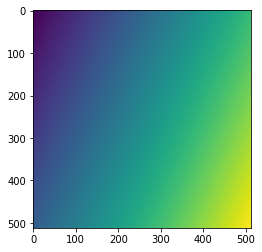

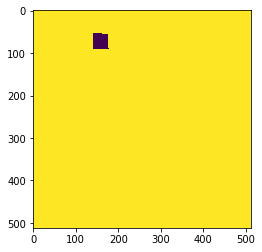

In [283]:
z_mask = np.ones((1080, 1920))
z_mask[300:350, 800:850] = 0.
new_image, new_mask = project_depth(12e3*np.ones((1080, 1920)),
                          z_mask,
                          (512, 512),
                          fc1, fc2, pc1, pc2,
                          RotationOfCamera2, TranslationOfCamera2)
plt.imshow(new_image)
plt.figure()
plt.imshow(new_mask)

In [217]:
mask = (xx_new >= 0) & (xx_new < imagesize2[1]) & (yy_new >= 0) & (yy_new < imagesize2[0])
print(xx_new[mask])
print(yy_new[mask])
print(z_new[mask])
new_image[yy_new[mask], xx_new[mask]] = z_new[mask]

[  0   0   1 ... 510 510 511]
[  0   0   0 ... 511 511 511]
[12129.25342378 12130.01561801 12130.77781224 ... 13027.8223059
 13028.58450013 13029.34669436]


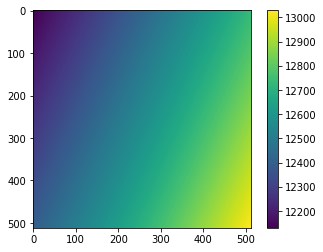

In [219]:
plt.imshow(new_image)
plt.colorbar()

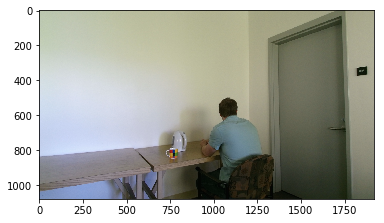

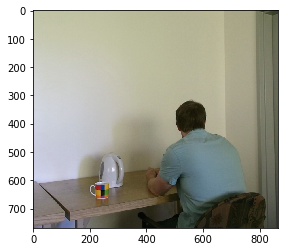

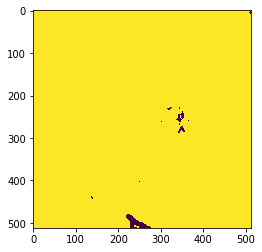

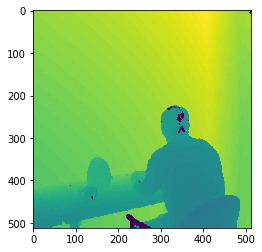

In [328]:
# Check on new image
import os
scenedir = "figures/midas/8_30_conference_room2_scene"
# scenedir = "figures/midas/8_29_kitchen_scene"

rgb = plt.imread(os.path.join(scenedir, "rgb.png"))
plt.figure()
plt.imshow(rgb)

rgb_cropped = plt.imread(os.path.join(scenedir, "rgb_cropped.png"))
plt.figure()
plt.imshow(rgb_cropped)

mask = plt.imread(os.path.join(scenedir, "mask.png"))
plt.figure()
plt.imshow(mask)

gt_z = plt.imread(os.path.join(scenedir, "gt_z.png"))
plt.figure()
plt.imshow(gt_z)
mask_proj = plt.imread(os.path.join(scenedir, "mask_proj.png"))


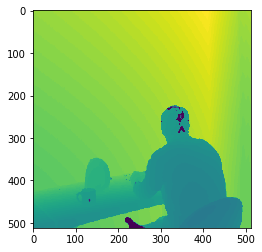

In [354]:
gt_z_undistorted = undistort_img(gt_z, fc2, pc2, rdc2, tdc2)
plt.imshow(gt_z_undistorted)

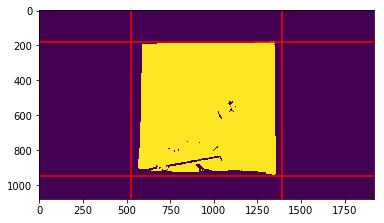

In [329]:
crop = np.load(os.path.join(scenedir, "crop.npy"))
plt.imshow(mask_proj)
plt.axhline(y=crop[0], color='r')
plt.axhline(y=crop[1], color='r')
plt.axvline(x=crop[2], color='r')
plt.axvline(x=crop[3], color='r')


In [330]:
np.load(os.path.join(scenedir, "pred_metrics.npy"), allow_pickle=True)

array({'delta1': 0.8590888381004333, 'delta2': 0.9969081878662109, 'delta3': 0.9991225004196167, 'rel_abs_diff': 0.13817498087882996, 'rel_sqr_diff': 0.06256047636270523, 'log10': 0.05685531347990036, 'mse': 0.1290866583585739, 'rmse': 0.3592863082885742, 'log_rmse': 0.16218949854373932},
      dtype=object)

In [331]:
np.load(os.path.join(scenedir, "init_metrics.npy"), allow_pickle=True)

array({'delta1': 0.07324058562517166, 'delta2': 0.16186679899692535, 'delta3': 0.4076763093471527, 'rel_abs_diff': 0.628620982170105, 'rel_sqr_diff': 1.3699854612350464, 'log10': 0.3187447190284729, 'mse': 3.2779288291931152, 'rmse': 1.8105051517486572, 'log_rmse': 0.7955963015556335},
      dtype=object)

In [332]:
np.load(os.path.join(scenedir, "med_scaled_metrics.npy"), allow_pickle=True)

array({'delta1': 0.4916190207004547, 'delta2': 0.6183701753616333, 'delta3': 0.8073977828025818, 'rel_abs_diff': 0.5647152066230774, 'rel_sqr_diff': 2.3283164501190186, 'log10': 0.17212170362472534, 'mse': 5.811213493347168, 'rmse': 2.4106459617614746, 'log_rmse': 0.562131404876709},
      dtype=object)

In [333]:
mask_proj_crop = plt.imread(os.path.join(scenedir, "mask_proj_crop.png"))

mask_proj_crop.shape

(768, 864)

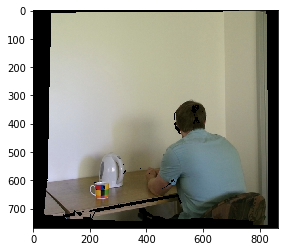

In [334]:
masked = rgb_cropped*mask_proj_crop[..., np.newaxis]
plt.imshow(masked)

In [335]:
d = np.load(os.path.join(scenedir, "mins_and_maxes.npy"), allow_pickle=True).item()
vmin = d["min_z"]
vmax = d["max_z"]


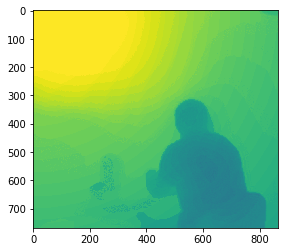

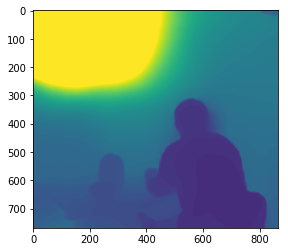

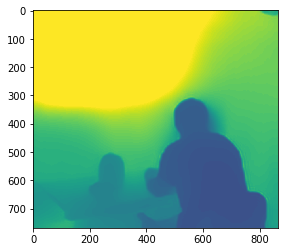

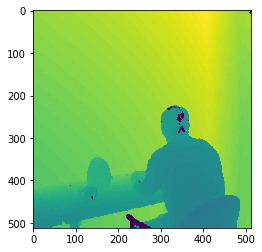

In [336]:
pred = plt.imread(os.path.join(scenedir, "z_pred.png"))
plt.figure()
plt.imshow(pred, vmin=np.min(gt_z), vmax=np.max(gt_z))

init = plt.imread(os.path.join(scenedir, "z_init.png"))
plt.figure()
plt.imshow(init, vmin=np.min(gt_z), vmax=np.max(gt_z))

med = plt.imread(os.path.join(scenedir, "z_med_scaled.png"))
plt.figure()
plt.imshow(med, vmin=np.min(gt_z), vmax=np.max(gt_z))

plt.figure()
plt.imshow(gt_z)

In [ ]:
pred = plt.imread(os.path.join(scenedir, "z_pred.png"))
